In [1]:
import numpy as np
np.set_printoptions(linewidth = 150, precision = 4, suppress = True)

In [2]:
data = np.loadtxt('../NC-Data.csv', delimiter=',', dtype=str)
data = data[1:].astype(float)
# Synthesize columns holding observations, reproducing the cov matrix.
raw_data = np.linalg.cholesky(data).T
np.testing.assert_allclose(data, raw_data.T @ raw_data)
data

array([[ 1.    , -0.0461,  0.2312, ...,  0.2704,  0.4664,  0.3672],
       [-0.0461,  1.    , -0.0671, ..., -0.0515, -0.0944, -0.0349],
       [ 0.2312, -0.0671,  1.    , ...,  0.147 ,  0.2608,  0.6313],
       ...,
       [ 0.2704, -0.0515,  0.147 , ...,  1.    ,  0.2066,  0.1538],
       [ 0.4664, -0.0944,  0.2608, ...,  0.2066,  1.    ,  0.3486],
       [ 0.3672, -0.0349,  0.6313, ...,  0.1538,  0.3486,  1.    ]])

In [3]:
nodes = np.loadtxt('../NC-K7-Trace-Nodes.csv', delimiter=',', dtype=str)
nodes = nodes[1:].astype(float)
bounds = np.loadtxt('../NC-K7-Trace-Bounds.csv', delimiter=',', dtype=str)
bounds = bounds[1:].astype(float)

In [4]:
# Bounds corresponding to a column of nodes.
print(bounds[:,-1])
stoch_lb = bounds[0, :]
gershgorin_ub = bounds[1, :]
trace_ub = bounds[2, :]


[5.6132 6.5066 7.    ]


In [5]:
import scipy.special
def ncr(n,k):
    return int(scipy.special.binom(n,k))
ncr(101,7)

17199613200

In [6]:
def combination(n, p, x):
    result = [None for i in range(p)]
    r = 0
    k = 0
    for i in range(p-1):
        result[i] = result[i-1] if i>0 else 0
        result[i] += 1
        r = ncr(n-result[i], p-(i+1))
        k += r
        while k < x:
            result[i] += 1
            r = ncr(n-result[i], p-(i+1))
            k += r
        k -= r
    result[p-1] = result[p-2] + x - k
    return result

In [7]:
import tensorflow as tf

In [8]:
def pascal(n, max_k=None):
    max_k = n if max_k is None else max_k
    result = np.zeros([n,n], np.int64)
    result[:, 0] = 1
    for i in range(1, n):
        for j in range(1, min(i+1, max_k)):
            result[i, j] = result[i-1, j-1] + result[i-1, j]
    return result

In [9]:
ncr = tf.constant(pascal(102, 8))

In [10]:
ncr.numpy().max()

17199613200

In [11]:
@tf.function(jit_compile=True)
def combination(n, p, x):
    result = tf.TensorArray(ncr.dtype, size=p)
    r = tf.constant(0, ncr.dtype)
    k = tf.constant(0, ncr.dtype)
    next_value = tf.constant(0, ncr.dtype)
    for i in tf.range(p-1):
        next_value += 1
        index = tf.cast(i, tf.int64)
        r = ncr[n-next_value, p-(index+1)]
        k += r
        while k < x:
            next_value += 1
            r = ncr[n-next_value, p-(index+1)]
            k += r
        k -= r
        result = result.write(i, next_value)
    result = result.write(p-1, next_value + x - k)
    return result.stack()

In [12]:
@tf.function(jit_compile=True)
def combinations_batch(n, k, start, limit):
    return tf.map_fn(
        lambda i: combination(n, k, i),
        tf.range(start, limit),
        dtype=tf.int64)

In [13]:
data = tf.constant(data, tf.float32)
raw_data = tf.constant(raw_data, tf.float32)

In [14]:
# Selected: indicator is 1.
# Free: indicator is 0.
def brute_force_eigvalsh(k, selected, free):
    choices = combinations_batch(free.shape[0], k - selected.shape[0], 1, 1+ncr[free.shape[0], k - selected.shape[0]]) - 1
    choices = tf.gather(free, choices)
    choices = tf.concat(
        [
            # Broadcast selected (repeat along the outer axis, N times)
            selected[None, :] + 0 * choices[:, 0:1],
            choices,
        ],
        axis=1,
    )
    eigvals = tf.linalg.eigvalsh(_simple_select_hermitian(data, choices))
    which_max = tf.argmax(tf.reduce_max(eigvals, axis=-1))
    return tf.reduce_max(eigvals[which_max, :]), choices[which_max]

@tf.function(jit_compile=True)
def _simple_select_hermitian(mat, choices):
    choices = choices[:, None, :]
    choices_lookup = tf.concat(
        [
            (choices + 0 * tf.transpose(choices, [0, 2, 1]))[:, :, :, None],
            (tf.transpose(choices, [0, 2, 1]) + 0 * choices)[:, :, :, None],
        ],
        axis=3
    )
    return tf.gather_nd(mat, choices_lookup)

In [15]:
# Selected: indicator is 1.
# Free: indicator is 0.
@tf.function(jit_compile=True)
def upper_bound_sparse_pca_metric(choices, XU, sigma_residual):
    linear_term = tf.reduce_sum(
        tf.gather(tf.square(XU), choices),
        axis=1,
    )

    sigma_indexing = tf.concat(
        [
            (choices[:, :, None] + 0 * choices[:, None, :])[:, :, :, None],
            (choices[:, None, :] + 0 * choices[:, :, None])[:, :, :, None],
        ],
        axis=3,
    )
    sigma_residual = tf.gather_nd(sigma_residual, sigma_indexing)
    v = tf.gather(tf.squeeze(XU, axis=1), choices)[:, :, None]
    nonlinear_term = tf.linalg.norm(
        tf.squeeze(tf.linalg.matmul(sigma_residual, v), axis=2),
        axis=1,
    ) / tf.linalg.norm(tf.squeeze(v, axis=2), axis=1)

    return tf.squeeze(linear_term, axis=1) + nonlinear_term

def upper_bound_sparse_pca(k, selected, free):
    selected_raw_data = tf.transpose(
        tf.gather(
            tf.transpose(raw_data),
            selected))
    U = tf.linalg.svd(selected_raw_data)[1][:, 0]
    XU = tf.linalg.matmul(raw_data, U[:, None], adjoint_a=True)
    # XU XU' + sigma_residual == sigma
    sigma_residual = data - tf.linalg.matmul(XU, XU, adjoint_b=True)

    choices = combinations_batch(free.shape[0], k - selected.shape[0], 1, 1+ncr[free.shape[0], k - selected.shape[0]]) - 1
    choices = tf.gather(free, choices)
    choices = tf.concat(
        [
            # Broadcast selected (repeat along the outer axis, N times)
            selected[None, :] + 0 * choices[:, 0:1],
            choices,
        ],
        axis=1,
    )

    ub = upper_bound_sparse_pca_metric(choices, XU, sigma_residual)
    which_max = tf.argmax(ub)
    return ub[which_max], choices[which_max]

In [27]:
brute_force = np.full(stoch_lb.shape, np.nan)
ipsen_brute_force_ub = np.full(stoch_lb.shape, np.nan)

k = 7
for i in range(nodes.shape[1]):
    selected, = tf.constant(np.where(nodes[:, i] == 1))
    free, = tf.constant(np.where(nodes[:, i] == -1))
    k_remaining = k - len(selected)
    if k_remaining == 0:
        brute_force[i] = stoch_lb[i]
        ipsen_brute_force_ub[i] = stoch_lb[i]
    elif ncr[len(free), k_remaining] <= 20_000_000:
        brute_force[i] = brute_force_eigvalsh(k, selected, free)[0]
        ipsen_brute_force_ub[i] = upper_bound_sparse_pca(k, selected, free)[0]

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

<AxesSubplot: >

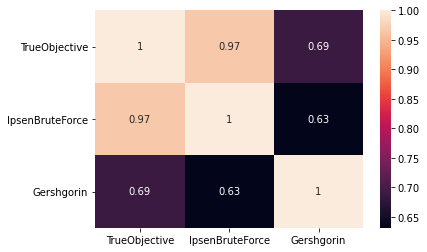

In [29]:
sns.heatmap(
    pd.DataFrame(
        {
            'TrueObjective': brute_force,
            'IpsenBruteForce': ipsen_brute_force_ub,
            'Gershgorin': gershgorin_ub,
        }
    ).corr(method = 'spearman'),
    annot=True
)

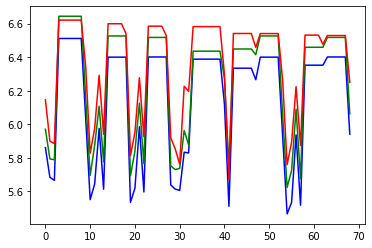

In [30]:
plt.plot(brute_force[(nodes == 1).sum(axis=0) == 4], 'blue')
plt.plot(ipsen_brute_force_ub[(nodes == 1).sum(axis=0) == 4], 'green')
plt.plot(gershgorin_ub[(nodes == 1).sum(axis=0) == 4], 'red')

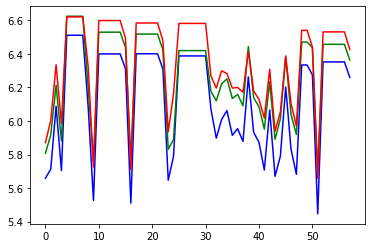

In [31]:
plt.plot(brute_force[(nodes == 1).sum(axis=0) == 3], 'blue')
plt.plot(ipsen_brute_force_ub[(nodes == 1).sum(axis=0) == 3], 'green')
plt.plot(gershgorin_ub[(nodes == 1).sum(axis=0) == 3], 'red')

In [33]:
# Correctness: Ipsen always bounded from below by the actual optimum.
np.where(ipsen_brute_force_ub < brute_force)[0]

array([], dtype=int64)